In [ ]:
import pandas as pd

In [ ]:
k=pd.read_csv("/content/drive/MyDrive/encrypted.csv",header=None)

In [ ]:
df=k.copy()

In [ ]:
copy_df=df.copy()

In [ ]:
copy_df.head()

,0,1,2,3
0,BlockCipher,AES-128,1,0ac1d7274c1f90b0f386d76bb84ef47990afc2c90e70c...
1,BlockCipher,Triple-DES,1,fb33c1f018339f01427793223992dc964bc04c064a98c...
2,BlockCipher,Blowfish,1,d3e59d4c6b095083075fe1620fa371fd496e008db1d0b...
3,BlockCipher,CAST-128,1,7d29e9cc5422da3f2a3f69fae4dbdaa7f3ee17ec8bd96...
4,BlockCipher,AES-128,2,a3aa833397ceb8ecb3d564a537928ae1f43da04973783...


In [ ]:
copy_df['algorithm'] = copy_df[1] + "_" + copy_df[2].apply(lambda x: "" if x=="None" else str(x))


In [ ]:
import numpy as np

In [ ]:
copy_df.head()

,0,1,2,3,algorithm
0,BlockCipher,AES-128,1,0ac1d7274c1f90b0f386d76bb84ef47990afc2c90e70c...,AES-128_ 1
1,BlockCipher,Triple-DES,1,fb33c1f018339f01427793223992dc964bc04c064a98c...,Triple-DES_ 1
2,BlockCipher,Blowfish,1,d3e59d4c6b095083075fe1620fa371fd496e008db1d0b...,Blowfish_ 1
3,BlockCipher,CAST-128,1,7d29e9cc5422da3f2a3f69fae4dbdaa7f3ee17ec8bd96...,CAST-128_ 1
4,BlockCipher,AES-128,2,a3aa833397ceb8ecb3d564a537928ae1f43da04973783...,AES-128_ 2


In [ ]:
copy_df[3] = copy_df[3].apply(lambda k: k[1:] )

In [ ]:
# def transformer_lis(k):
#   binary_list_main=[]
#   for hex_string in k:
#     pairs = [hex_string[i:i+2] for i in range(0, len(hex_string), 2)]
#     binary_list = [bin(int(pair, 16))[2:].zfill(8) for pair in pairs]
#     binary_list_main.append(binary_list)
#   return binary_list_main

In [ ]:
from joblib import Parallel, delayed
import pandas as pd

# Define the transformer function
def transformer_str(k):
    binary_string_final = ""
    for hex_string in k:
        pairs = [hex_string[i:i+2] for i in range(0, len(hex_string), 2)]
        binary_list = [bin(int(pair, 16))[2:].zfill(8) for pair in pairs]
        binary_string = ''.join(binary_list)
        binary_string_final += binary_string
    return binary_string_final

# Parallelize the apply function
def parallelize_dataframe_apply(df, func, column):
    n_jobs = -1  # Use all available cores
    result = Parallel(n_jobs=n_jobs)(delayed(func)(row) for row in df[column])
    return result

# Example usage
copy_df[4] = parallelize_dataframe_apply(copy_df, transformer_str, column=3)


In [ ]:
def entropy_analysis(k):
  #this function will be used to measure the randomness of cipher text this feature
  # might be a little less useful
  prob_0 = k.count('0') / len(k)
  prob_1 = k.count('1') / len(k)

    # Avoid log(0) by ensuring probabilities > 0
  entropy = 0
  if prob_0 > 0:
      entropy -= prob_0 * np.log2(prob_0)
  if prob_1 > 0:
      entropy -= prob_1 * np.log2(prob_1)

  return entropy


In [ ]:
def frequency_test(k):
  #checks the deviation form stability
    E_i = 0.5
    prob_0 = k.count('0') / len(k)
    prob_1 = k.count('1') / len(k)
    chi_squared = (((prob_0 - E_i) ** 2) / E_i) + (((prob_1 - E_i) ** 2) / E_i)
    deviation = chi_squared ** 0.5  # Taking the square root for stability test

    return deviation


In [ ]:
from itertools import groupby
def run_length(k):
  #used to find the A run of length k
  #consists of exactly k identical bits and
  #is bounded before and after with a bit of opposite value.
  runs = [(key, len(list(group))) for key, group in groupby(k)]

    # Separate runs of 0s and 1s
  run_lengths_0 = [length for bit, length in runs if bit == '0']
  run_lengths_1 = [length for bit, length in runs if bit == '1']

    # Calculate mean run lengths, handle empty cases gracefully
  mean_run_0 = np.mean(run_lengths_0) if run_lengths_0 else 0
  mean_run_1 = np.mean(run_lengths_1) if run_lengths_1 else 0

  return [mean_run_0, mean_run_1]

In [ ]:
def hamming_weight(k):
  #counts number of 1
  return k.count('1')

In [ ]:
def bit_transition(segment):
    """
    Count the number of bit transitions (changes from 0 to 1 or 1 to 0) in the binary string.

    Parameters:
        segment (str): Binary string.

    Returns:
        int: Number of transitions.
    """
    # Convert the binary string to a list of integers
    data = list(map(int, segment))

    # Initialize count of transitions
    count = 0

    # Loop through adjacent bits
    for i in range(len(data) - 1):
        count += abs(data[i] - data[i + 1])  # Compute transition

    return count


In [ ]:
def binary_skewness_kurtosis(k):
    # Convert binary string into a list of integers
    data = list(map(int, k))
    n = len(data)
    # Calculate Mean
    mean = sum(data) / n
    # Calculate Median
    sorted_data = sorted(data)
    if n % 2 == 1:  # Odd number of elements
        median = sorted_data[n // 2]
    else:  # Even number of elements
        median = (sorted_data[n // 2 - 1] + sorted_data[n // 2]) / 2
    # Calculate Standard Deviation
    variance = sum((x - mean) ** 2 for x in data) / n
    std_dev = variance ** 0.5
    if std_dev == 0:  # Handle edge case where all elements are identical
        return 0,0
    # Calculate Skewness
    skewness = 3 * (mean - median) / std_dev
    # Calculate Kurtosis
    kurtosis = sum((x - mean) ** 4 for x in data) / (n * std_dev ** 4) - 3

    return skewness, kurtosis


In [ ]:
def autocorrelation(binary_seq, lag):
    # Convert binary string into a list of integers
    data = list(map(int, binary_seq))
    n = len(data)
    if lag >= n:
        return "Lag is too large for the sequence length."
    # Calculate Mean
    mean = sum(data) / n
    # Calculate Variance
    variance = sum((x - mean) ** 2 for x in data) / n
    if variance == 0:  # Handle edge case where all elements are identical
        return 0
    # Calculate Autocorrelation for the given lag
    autocorr = sum((data[t] - mean) * (data[t + lag] - mean) for t in range(n - lag)) / variance

    return autocorr


In [ ]:
import math

def fractal_dimension(binary_seq):
    """
    Compute the fractal dimension of a binary sequence.

    Parameters:
        binary_seq (str): Binary string representing the sequence.

    Returns:
        float: Fractal dimension of the sequence.
    """
    # Convert binary string into a list of integers
    data = list(map(int, binary_seq))
    n = len(data)

    # Define possible scales
    scales = [2**i for i in range(1, int(math.log2(n)) + 1)] if n > 1 else []

    log_r = []
    log_Nr = []

    for r in scales:
        # Divide sequence into chunks of size r
        chunks = [data[i:i + r] for i in range(0, n, r)]

        # Count non-empty chunks (chunks with at least one "1")
        N_r = sum(1 for chunk in chunks if sum(chunk) > 0)

        # Avoid log(0) errors
        if N_r > 0 and r > 0:
            log_r.append(math.log(r))
            log_Nr.append(math.log(N_r))

    # Handle edge cases where log lists are empty
    if len(log_r) < 2 or len(log_Nr) < 2:
        return 0.0  # Cannot compute fractal dimension for insufficient data

    # Calculate slope (Fractal Dimension) using the formula: slope = Δy / Δx
    D = (log_Nr[-1] - log_Nr[0]) / (log_r[-1] - log_r[0])
    return D


In [ ]:
import numpy as np

def lyapunov_exponent(seq1, seq2):
    # Convert sequences to binary arrays
    data1 = np.array(list(map(int, seq1)))
    data2 = np.array(list(map(int, seq2)))

    if len(data1) != len(data2):
        return "Sequences must be of the same length."

    # Calculate Hamming distances over time
    distances = [np.sum(data1[:i] != data2[:i]) for i in range(1, len(data1))]

    # Avoid zero distances to prevent log(0) errors
    distances = np.array(distances)
    distances[distances == 0] = 1e-10  # Small value to avoid log(0)

    # Compute Lyapunov exponent
    lyapunov = np.mean(np.log(distances[1:] / distances[:-1]))
    return lyapunov


In [ ]:
def extract_features(binary_string):
    """
    Extract features from binary ciphertext for training a model.

    Parameters:
        binary_string (str): Binary sequence representing the ciphertext.

    Returns:
        dict: A dictionary containing extracted features.
    """
    import numpy as np

    # Feature: Length of ciphertext
    length = len(binary_string)

    # Feature: Frequency of '1's and '0's
    ones = binary_string.count('1') / length
    zeros = binary_string.count('0') / length

    # Feature: Spectral Density (FFT mean and variance)
    numeric_ciphertext = np.array([int(bit) for bit in binary_string]) * 2 - 1
    fft_result = np.fft.fft(numeric_ciphertext)
    spectral_density = np.abs(fft_result) ** 2
    spectral_mean = np.mean(spectral_density)
    spectral_variance = np.var(spectral_density)

    # Compile features into a dictionary
    features = [
         spectral_mean,
         spectral_variance
    ]

    return features


In [ ]:
def compute_convolution(ciphertext, kernel=[1,-1]):
    """
    Compute the convolution of a ciphertext with a given kernel.

    Parameters:
        ciphertext (list or np.array): Numeric representation of the ciphertext.
        kernel (list or np.array): Convolutional filter or kernel.

    Returns:
        np.array: Convolution result.
    """
    # Convert ciphertext and kernel to numpy arrays for efficient computation
    ciphertext = np.array(ciphertext)
    kernel = np.array(kernel)
    # Lengths of ciphertext and kernel
    ciphertext_len = len(ciphertext)
    kernel_len = len(kernel)
    # Length of the output
    output_len = ciphertext_len - kernel_len + 1
    # Initialize the convolution result
    convolution_result = np.zeros(output_len)
    # Perform the convolution
    for i in range(output_len):
        convolution_result[i] = np.sum(ciphertext[i:i+kernel_len] * kernel)
    return convolution_result

In [ ]:
import numpy as np
import pywt
import matplotlib.pyplot as plt

def compute_wavelet_transform(ciphertext, wavelet='haar'):
    """
    Compute the discrete wavelet transform (DWT) of a binary ciphertext.

    Parameters:
        ciphertext (str): Binary ciphertext (e.g., "10110").
        wavelet (str): Wavelet type (default is 'haar').

    Returns:
        list: Wavelet coefficients.
    """
    # Convert binary ciphertext to numeric form (1 -> 1, 0 -> -1)
    numeric_ciphertext = np.array([1 if bit == '1' else -1 for bit in ciphertext])

    # Perform Discrete Wavelet Transform (DWT)
    coeffs = pywt.wavedec(numeric_ciphertext, wavelet)

    return coeffs

In [ ]:
import zlib

def compute_ciphertext_complexity(ciphertext):
    """
    Compute the ciphertext complexity using zlib compression.

    Parameters:
        ciphertext (str): Ciphertext as a string.

    Returns:
        int: Length of the compressed ciphertext.
    """
    # Compress the ciphertext using zlib
    compressed_ciphertext = zlib.compress(ciphertext.encode())

    # Return the length of the compressed ciphertext
    return len(compressed_ciphertext)

In [ ]:
import pandas as pd
from joblib import Parallel, delayed

def extract_features_for_row(row, segment_sizes):
    """
    Extract features for a single row of the dataset.

    Parameters:
        row (pd.Series): A row from the dataset containing binary ciphertext in column 4.
        segment_sizes (list): List of segment sizes to extract features for.

    Returns:
        dict: A dictionary of features extracted for the row.
    """
    features = {}
    binary_string = row[4]  # Column containing binary ciphertext

    # Extract features for each segment size
    for size in segment_sizes:
        # Extract the segment of the required size
        segment = binary_string[:size]  # Binary segment (first `size` bits)

        # Pad with zeros if the segment is smaller than the required size
        segment = segment.ljust(size, '0')

        # Extract features for the segment
        features[f"entropy_{size}"] = entropy_analysis(segment)
        features[f"frequency_deviation_{size}"] = frequency_test(segment)
        features[f"mean_run_0_{size}"], features[f"mean_run_1_{size}"] = run_length(segment)
        features[f"hamming_weight_{size}"] = hamming_weight(segment)
        features[f"bit_transitions_{size}"] = bit_transition(segment)
        features[f"skewness_{size}"], features[f"kurtosis_{size}"] = binary_skewness_kurtosis(segment)
        features[f"autocorrelation_{size}"] = autocorrelation(segment, lag=4)
        features[f"fractal_dimension_{size}"] = fractal_dimension(segment)
        spectral_features = extract_features(segment)
        features[f"spectral_mean_{size}"] = spectral_features[0]
        features[f"spectral_variance_{size}"] = spectral_features[1]
        convolution_result = compute_convolution([int(bit) for bit in segment])
        features[f"convolution_{size}"] = sum(convolution_result)
        features[f"complexity_{size}"] = compute_ciphertext_complexity(segment)

    return features

def append_features_to_dataset(dataset, segment_sizes=[128,256,512,1024,2048,4096], n_jobs=-1):
    """
    Append features to the dataset for each ciphertext in column 4 using parallelization.

    Parameters:
        dataset (pd.DataFrame): Original dataset containing binary ciphertexts.
        segment_sizes (list): List of segment sizes to extract features for.
        n_jobs (int): Number of parallel jobs (-1 means using all available processors).

    Returns:
        pd.DataFrame: Updated dataset with appended feature columns.
    """
    # Extract features in parallel for each row
    results = Parallel(n_jobs=n_jobs)(
        delayed(extract_features_for_row)(row, segment_sizes) for _, row in dataset.iterrows()
    )

    # Combine the features back into the DataFrame
    features_df = pd.DataFrame(results)
    updated_dataset = pd.concat([dataset.reset_index(drop=True), features_df], axis=1)

    return updated_dataset

In [ ]:
 # Load your dataset
updated_dataset = append_features_to_dataset(copy_df)


In [ ]:
updated_dataset.to_csv("/content/drive/MyDrive/Updated_csv/Updated.csv", index=False)

In [ ]:
updated_dataset.to_csv("Updated.csv", index=False)

In [ ]:
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

In [ ]:
import pandas as pd

In [ ]:
df=pd.read_csv("/content/drive/MyDrive/Updated.csv")

In [ ]:
updated_dataset.to_csv("/content/drive/MyDrive/Updated_csv/Updated.csv", index=False)

In [ ]:
X_1=df.drop(columns=["algorithm", '0', '1', '2', '3', '4'])
y=y = df["algorithm"]

In [ ]:
df.head()

,0,1,2,3,algorithm,4,entropy_128,frequency_deviation_128,mean_run_0_128,mean_run_1_128,...,bit_transitions_4096,skewness_4096,kurtosis_4096,autocorrelation_4096,fractal_dimension_4096,spectral_mean_4096,spectral_variance_4096,convolution_4096,complexity_4096,algorithm_encoded
0,BlockCipher,AES-128,1,0ac1d7274c1f90b0f386d76bb84ef47990afc2c90e70c6...,AES-128_ 1,0000000000001010000011000000000100001101000001...,0.757878,0.562500,5.555556,1.647059,...,1280,1.734306,-0.673595,-1370.228013,-0.869987,4096.0,5.848191e+09,0.0,515,0
1,BlockCipher,Triple-DES,1,fb33c1f018339f01427793223992dc964bc04c064a98c8...,Triple-DES_ 1,0000111100001011000000110000001100001100000000...,0.798659,0.515625,6.062500,1.937500,...,1192,1.679039,-0.494333,-1284.289836,-0.865243,4096.0,6.558021e+09,0.0,515,20
2,BlockCipher,Blowfish,1,d3e59d4c6b095083075fe1620fa371fd496e008db1d0bf...,Blowfish_ 1,0000110100000011000011100000010100001001000011...,0.785560,0.531250,4.666667,1.428571,...,1245,1.746710,-0.711145,-1384.542661,-0.872211,4096.0,5.888527e+09,-1.0,526,7
3,BlockCipher,CAST-128,1,7d29e9cc5422da3f2a3f69fae4dbdaa7f3ee17ec8bd96b...,CAST-128_ 1,0000011100001101000000100000100100001110000010...,0.835116,0.468750,4.272727,1.545455,...,1253,1.723030,-0.638634,-1348.477922,-0.870332,4096.0,6.013086e+09,-1.0,529,12
4,BlockCipher,AES-128,2,a3aa833397ceb8ecb3d564a537928ae1f43da04973783b...,AES-128_ 2,0000101000000011000010100000101000001000000000...,0.835116,0.468750,4.272727,1.619048,...,1316,1.753477,-0.731236,-1396.662954,-0.873562,4096.0,5.674532e+09,0.0,525,1


In [ ]:
def chi_square_test(data):
    """Perform chi-square test against uniform distribution."""
    if len(data) == 0:
        return 0
    observed = np.bincount(np.frombuffer(data, dtype=np.uint8), minlength=256)
    expected = np.full(256, len(data)/256)
    chi_square = np.sum((observed - expected)**2 / expected)
    return chi_square


In [ ]:
import pandas as pd
import numpy as np
from joblib import Parallel, delayed

def chi_square_test(data):
    """Perform chi-square test against uniform distribution."""
    if len(data) == 0:
        return 0
    observed = np.bincount(np.frombuffer(data.encode('utf-8'), dtype=np.uint8), minlength=256)
    expected = np.full(256, len(data) / 256)
    chi_square = np.sum((observed - expected) ** 2 / expected)
    return chi_square

def extract_features_for_row(row, segment_sizes):
    """
    Extract features for a single row of the dataset.

    Parameters:
        row (pd.Series): A row from the dataset containing binary ciphertext in column 4.
        segment_sizes (list): List of segment sizes to extract features for.

    Returns:
        dict: A dictionary of features extracted for the row.
    """
    features = {}
    binary_string = row[4]  # Column containing binary ciphertext

    # Extract features for each segment size
    for size in segment_sizes:
        # Extract the segment of the required size
        segment = binary_string[:size]  # Binary segment (first `size` bits)

        # Pad with zeros if the segment is smaller than the required size
        segment = segment.ljust(size, '0')

        # Extract features for the segment
        features[f"chi_square_{size}"] = chi_square_test(segment)

    return features

def append_features_to_dataset(dataset, segment_sizes=[128, 256, 512, 1024, 2048, 4096], n_jobs=-1):
    """
    Append features to the dataset for each ciphertext in column 4 using parallelization.

    Parameters:
        dataset (pd.DataFrame): Original dataset containing binary ciphertexts.
        segment_sizes (list): List of segment sizes to extract features for.
        n_jobs (int): Number of parallel jobs (-1 means using all available processors).

    Returns:
        pd.DataFrame: Updated dataset with appended feature columns.
    """
    # Extract features in parallel for each row
    results = Parallel(n_jobs=n_jobs)(
        delayed(extract_features_for_row)(row, segment_sizes) for _, row in dataset.iterrows()
    )

    # Combine the features back into the DataFrame
    features_df = pd.DataFrame(results)
    updated_dataset = pd.concat([dataset.reset_index(drop=True), features_df], axis=1)

    return updated_dataset

In [ ]:
updated_df = append_features_to_dataset(df)
df=updated_df

In [ ]:
df.to_csv("/content/drive/MyDrive/new_df.csv", index=False)

In [ ]:
import numpy as np
import pywt
import matplotlib.pyplot as plt

def compute_wavelet_transform(ciphertext, wavelet='haar'):
    """
    Compute the discrete wavelet transform (DWT) of a binary ciphertext.

    Parameters:
        ciphertext (str): Binary ciphertext (e.g., "10110").
        wavelet (str): Wavelet type (default is 'haar').

    Returns:
        list: Wavelet coefficients.
    """
    # Convert binary ciphertext to numeric form (1 -> 1, 0 -> -1)
    numeric_ciphertext = np.array([1 if bit == '1' else -1 for bit in ciphertext])

    # Perform Discrete Wavelet Transform (DWT)
    coeffs = pywt.wavedec(numeric_ciphertext, wavelet)

    return coeffs

In [ ]:
import pandas as pd
import numpy as np
import pywt
from joblib import Parallel, delayed

def wavelet_transform_features(data, wavelet='haar', max_level=5):
    """
    Perform wavelet transform and extract features from the coefficients.

    Parameters:
        data (str): Binary ciphertext string.
        wavelet (str): Type of wavelet to use for the transform.
        max_level (int): Maximum level of decomposition.

    Returns:
        dict: Extracted wavelet features.
    """
    if len(data) == 0:
        return {}

    # Convert binary string to numeric values (1 for '1', -1 for '0')
    numeric_data = np.array([1 if bit == '1' else -1 for bit in data])

    # Perform wavelet transform
    coeffs = pywt.wavedec(numeric_data, wavelet, level=max_level)

    # Extract features from each level
    features = {}
    for level, coeff in enumerate(coeffs):
        features[f'wavelet_mean_level_{level}'] = np.mean(coeff)
        features[f'wavelet_std_level_{level}'] = np.std(coeff)
        features[f'wavelet_energy_level_{level}'] = np.sum(np.square(coeff))
        features[f'wavelet_entropy_level_{level}'] = -np.sum(coeff * np.log2(np.abs(coeff + 1e-10)))

    return features

def extract_features_for_row(row, segment_sizes, wavelet='haar', max_level=4):
    """
    Extract wavelet features for a single row of the dataset.

    Parameters:
        row (pd.Series): A row from the dataset containing binary ciphertext in column 4.
        segment_sizes (list): List of segment sizes to extract features for.
        wavelet (str): Type of wavelet to use for the transform.
        max_level (int): Maximum level of decomposition.

    Returns:
        dict: A dictionary of features extracted for the row.
    """
    features = {}
    binary_string = row[4]  # Column containing binary ciphertext

    # Extract features for each segment size
    for size in segment_sizes:
        # Extract the segment of the required size
        segment = binary_string[:size]  # Binary segment (first `size` bits)

        # Pad with zeros if the segment is smaller than the required size
        segment = segment.ljust(size, '0')

        # Extract wavelet features for the segment
        wavelet_features = wavelet_transform_features(segment, wavelet=wavelet, max_level=max_level)
        features.update({f"{key}_{size}": value for key, value in wavelet_features.items()})

    return features

def append_features_to_dataset(dataset, segment_sizes=[128, 256, 512, 1024, 2048, 4096], wavelet='haar', max_level=4, n_jobs=-1):
    """
    Append wavelet transform features to the dataset for each ciphertext in column 4 using parallelization.

    Parameters:
        dataset (pd.DataFrame): Original dataset containing binary ciphertexts.
        segment_sizes (list): List of segment sizes to extract features for.
        wavelet (str): Type of wavelet to use for the transform.
        max_level (int): Maximum level of decomposition.
        n_jobs (int): Number of parallel jobs (-1 means using all available processors).

    Returns:
        pd.DataFrame: Updated dataset with appended feature columns.
    """
    # Extract features in parallel for each row
    results = Parallel(n_jobs=n_jobs)(
        delayed(extract_features_for_row)(row, segment_sizes, wavelet=wavelet, max_level=max_level)
        for _, row in dataset.iterrows()
    )

    # Combine the features back into the DataFrame
    features_df = pd.DataFrame(results)
    updated_dataset = pd.concat([dataset.reset_index(drop=True), features_df], axis=1)

    return updated_dataset


In [ ]:
updated_df = append_features_to_dataset(new_df)


In [ ]:
from scipy.fft import fft
from scipy.stats import entropy

def spectral_entropy(binary_string):
    numeric_data = np.array([1 if bit == '1' else -1 for bit in binary_string])
    fft_values = np.abs(fft(numeric_data))
    normalized_fft = fft_values / np.sum(fft_values)
    return entropy(normalized_fft)

def dominant_frequency_magnitude(binary_string):
    numeric_data = np.array([1 if bit == '1' else -1 for bit in binary_string])
    fft_values = np.abs(fft(numeric_data))
    return np.max(fft_values)

def power_spectral_density_peaks(binary_string, num_peaks=3):
    numeric_data = np.array([1 if bit == '1' else -1 for bit in binary_string])
    fft_values = np.abs(fft(numeric_data)) ** 2
    return sorted(fft_values, reverse=True)[:num_peaks]


In [ ]:
def entropy_gradient(binary_string, block_size):
    entropies = []
    for i in range(0, len(binary_string), block_size):
        block = binary_string[i:i + block_size]
        counts = np.bincount([int(bit) for bit in block], minlength=2)
        probabilities = counts / counts.sum()
        entropies.append(-np.sum(probabilities * np.log2(probabilities + 1e-10)))
    return np.gradient(entropies)


In [ ]:
def adjacent_bit_probability(binary_string):
    transitions = [1 if binary_string[i] != binary_string[i + 1] else 0 for i in range(len(binary_string) - 1)]
    return sum(transitions) / len(transitions)

def bit_pair_frequency(binary_string):
    pairs = [binary_string[i:i + 2] for i in range(len(binary_string) - 1)]
    return {pair: pairs.count(pair) / len(pairs) for pair in ['00', '01', '10', '11']}


In [ ]:
import nolds

def hurst_exponent(binary_string):
    numeric_data = np.array([1 if bit == '1' else -1 for bit in binary_string])
    return nolds.hurst_rs(numeric_data)

def detrended_fluctuation_analysis(binary_string):
    numeric_data = np.array([1 if bit == '1' else -1 for bit in binary_string])
    return nolds.dfa(numeric_data)


In [ ]:
from pyunicorn.timeseries.recurrence_plot import RecurrencePlot

def recurrence_quantification_analysis(binary_string, threshold=0.5):
    numeric_data = np.array([1 if bit == '1' else -1 for bit in binary_string])
    rp = RecurrencePlot(numeric_data, threshold=threshold)
    return rp.recurrence_rate()


In [ ]:
import pandas as pd
import numpy as np
from joblib import Parallel, delayed

# Functions for feature extraction


# Extract features for a single row
def extract_features_for_row(row, segment_sizes):
    features = {}
    binary_string = row['4']  # Column containing binary ciphertext

    for size in segment_sizes:
        # Extract the segment of the required size
        segment = binary_string[:size]
        segment = segment.ljust(size, '0')  # Pad with zeros if smaller than size

        # Compute features
        features[f"recurrence_rate_{size}"] = recurrence_quantification_analysis(segment)
        features[f"hurst_exponent_{size}"] = hurst_exponent(segment)
        features[f"dfa_{size}"] = detrended_fluctuation_analysis(segment)
        bit_freq = bit_pair_frequency(segment)
        for pair, freq in bit_freq.items():
            features[f"bit_pair_freq_{pair}_{size}"] = freq
        features[f"entropy_gradient_{size}"] = entropy_gradient(segment)
        features[f"adjacent_bit_probability_{size}"] = adjacent_bit_probability(segment)
        features[f"spectral_entropy_{size}"] = spectral_entropy(segment)
        features[f"dominant_frequency_magnitude_{size}"] = dominant_frequency_magnitude(segment)
        peaks = power_spectral_density_peaks(segment)
        for i, peak in enumerate(peaks):
            features[f"power_spectral_peak_{i+1}_{size}"] = peak

    return features

# Append features to the dataset
def append_features_to_dataset(dataset, segment_sizes=[128, 256, 512, 1024, 2048, 4096], n_jobs=-1):
    results = Parallel(n_jobs=n_jobs)(
        delayed(extract_features_for_row)(row, segment_sizes) for _, row in dataset.iterrows()
    )
    features_df = pd.DataFrame(results)
    updated_dataset = pd.concat([dataset.reset_index(drop=True), features_df], axis=1)
    return updated_dataset


In [ ]:
updated_df = append_features_to_dataset(updated_df)


In [ ]:
updated_df.to_csv("new_df1.csv", index=False)

In [ ]:
import pandas as pd

In [ ]:
new_df=pd.read_csv("/content/drive/MyDrive/new_df1.csv")

In [ ]:
import numpy as np

In [ ]:
copy_dfer=new_df.copy()

In [ ]:
new_df.head()

,0,1,2,3,algorithm,4,entropy_128,frequency_deviation_128,mean_run_0_128,mean_run_1_128,...,bit_pair_freq_01_4096,bit_pair_freq_10_4096,bit_pair_freq_11_4096,entropy_gradient_4096,adjacent_bit_probability_4096,spectral_entropy_4096,dominant_frequency_magnitude_4096,power_spectral_peak_1_4096,power_spectral_peak_2_4096,power_spectral_peak_3_4096
0,BlockCipher,AES-128,1,0ac1d7274c1f90b0f386d76bb84ef47990afc2c90e70c6...,AES-128_ 1,0000000000001010000011000000000100001101000001...,0.757878,0.562500,5.555556,1.647059,...,0.156288,0.156288,0.094261,[ 0.27077583 0.09300786 -0.13538791 0.022935...,0.312576,8.107188,2044.0,4177936.0,1.777366e+06,1.777366e+06
1,BlockCipher,Triple-DES,1,fb33c1f018339f01427793223992dc964bc04c064a98c8...,Triple-DES_ 1,0000111100001011000000110000001100001100000000...,0.798659,0.515625,6.062500,1.937500,...,0.145543,0.145543,0.093040,[-0.17048361 -0.11607491 0. 0.057532...,0.291087,8.093398,2142.0,4588164.0,1.695355e+06,1.695355e+06
2,BlockCipher,Blowfish,1,d3e59d4c6b095083075fe1620fa371fd496e008db1d0bf...,Blowfish_ 1,0000110100000011000011100000010100001001000011...,0.785560,0.531250,4.666667,1.428571,...,0.152137,0.151893,0.101099,[-0.08476011 -0.06907988 -0.09300786 0.049634...,0.304029,8.100660,2022.0,4088484.0,1.912901e+06,1.912901e+06
3,BlockCipher,CAST-128,1,7d29e9cc5422da3f2a3f69fae4dbdaa7f3ee17ec8bd96b...,CAST-128_ 1,0000011100001101000000100000100100001110000010...,0.835116,0.468750,4.272727,1.545455,...,0.153114,0.152869,0.094994,[ 0. -0.11594302 0.03560682 0.115943...,0.305983,8.103084,2064.0,4260096.0,1.782486e+06,1.782486e+06
4,BlockCipher,AES-128,2,a3aa833397ceb8ecb3d564a537928ae1f43da04973783b...,AES-128_ 2,0000101000000011000010100000101000001000000000...,0.835116,0.468750,4.272727,1.619048,...,0.160684,0.160684,0.094017,[-0.05339966 0.04238005 0.04963499 0. ...,0.321368,8.110214,2010.0,4040100.0,1.832733e+06,1.832733e+06


In [ ]:
df=new_df[new_df['0']=="StreamCipher"]

In [ ]:
import numpy as np
import pandas as pd
import ast

def parse_and_convert_column1(column):
    """
    Converts a string representation of a list into a numpy array with comma-separated values.
    Handles strings with newline characters and preserves the input if parsing fails.
    """
    def convert_string_to_array(value):
        """
        Converts a string representation of a list into a numpy array of floats.
        Handles newline characters and spaces.
        """
        if isinstance(value, str):
            try:
                # Remove newline characters and extra spaces
                cleaned_value = value.replace('\n', ' ').replace('[', '').replace(']', '').strip()
                # Parse the string into a list of numbers
                parsed_value = [float(x) for x in cleaned_value.split()]
                # Convert to numpy array if the parsed value is a list
                return np.array(parsed_value, dtype=float)
            except Exception as e:
                print(f"Error parsing value: {value} -> {e}")
                return value  # Return the original value if parsing fails
        return value  # Return the value as is if it's not a string

    # Apply conversion to the column
    converted_column = column.apply(convert_string_to_array)
    print(f"Column after conversion:\n{converted_column.head()}")  # Debugging step
    return converted_column

def convert_dataframe(df):
    """
    Converts specific columns containing stringified lists to numpy arrays with comma-separated values.
    Preserves specified columns like '0', '1', '2', '3', 'algorithm', and '4'.
    """
    # Columns to preserve
    preserved_columns = ['0', '1', '2', '3', 'algorithm', '4']

    # Iterate through columns, convert only those not in the preserved list
    for column in df.columns:
        if column not in preserved_columns:
            print(f"Processing column: {column}")  # Debugging step
            df[column] = parse_and_convert_column1(df[column])  # Assign the converted column back to the DataFrame

    return df  # Return the modified DataFrame

In [ ]:
new_df['wavelet_mean_level_2_512']

,wavelet_mean_level_2_512
0,0.000000
1,-0.011049
2,0.011049
3,0.000000
4,-0.011049
...,...
25020,0.000000
25021,0.000000
25022,0.000000
25023,0.000000


In [ ]:
que_df=convert_dataframe(copy_dfer)

Processing column: entropy_128
Column after conversion:
0    None
1    None
2    None
3    None
4    None
Name: entropy_128, dtype: object
Processing column: frequency_deviation_128
Column after conversion:
0    None
1    None
2    None
3    None
4    None
Name: frequency_deviation_128, dtype: object
Processing column: mean_run_0_128
Column after conversion:
0    None
1    None
2    None
3    None
4    None
Name: mean_run_0_128, dtype: object
Processing column: mean_run_1_128
Column after conversion:
0    None
1    None
2    None
3    None
4    None
Name: mean_run_1_128, dtype: object
Processing column: hamming_weight_128
Column after conversion:
0    None
1    None
2    None
3    None
4    None
Name: hamming_weight_128, dtype: object
Processing column: bit_transitions_128
Column after conversion:
0    None
1    None
2    None
3    None
4    None
Name: bit_transitions_128, dtype: object
Processing column: skewness_128
Column after conversion:
0    None
1    None
2    None
3    None
4  

In [ ]:
que_df.describe()

,0,1,2,3,algorithm,4,entropy_128,frequency_deviation_128,mean_run_0_128,mean_run_1_128,...,bit_pair_freq_01_4096,bit_pair_freq_10_4096,bit_pair_freq_11_4096,entropy_gradient_4096,adjacent_bit_probability_4096,spectral_entropy_4096,dominant_frequency_magnitude_4096,power_spectral_peak_1_4096,power_spectral_peak_2_4096,power_spectral_peak_3_4096
count,25025,25025,25025,25025,25025,25025,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
unique,3,9,6,25025,25,25025,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
top,BlockCipher,AES-128,None,41eed67d380a33cf9060e948ef2f49ceb87b082b8cd5f0...,AES-128_ 1,0000010000000001000011100000111000001101000001...,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,20020,5005,5005,1,1001,1,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
copy_dfer['entropy_gradient_2048'][0]

In [ ]:
new_df=que_df.copy()

In [ ]:
new_df['entropy_gradient_2048'][0]

'[ 0.27077583  0.09300786 -0.13538791  0.02293516  0.15154983 -0.02293516\n -0.01616192  0.         -0.06907988 -0.05753293  0.02669983  0.\n  0.04238005  0.0308331  -0.22358687  0.          0.12367389  0.02669983\n  0.          0.02293516  0.0308331  -0.11594302  0.02669983  0.03547493\n  0.08160564  0.0308331  -0.02306367  0.04963499 -0.15154983 -0.156792\n  0.03547493  0.10715701  0.          0.09827777  0.0308331  -0.07157794\n  0.06907988  0.04238005 -0.09991299 -0.04238005  0.08046809  0.02293516\n -0.04963499  0.03560682  0.0852418  -0.11607491 -0.0852418   0.09991299\n  0.         -0.04238005  0.04963499  0.07157794 -0.02293516 -0.09827777\n -0.02669983  0.          0.02669983 -0.0308331  -0.02669983  0.08046809\n  0.06907988  0.0194449   0.01616192  0.03232384]'

In [ ]:
import pandas as pd

In [ ]:
new_df=pd.read_csv("/content/drive/MyDrive/new_df1_12.csv")

In [ ]:
new_df.head()

,0,1,2,3,algorithm,4,entropy_128,frequency_deviation_128,mean_run_0_128,mean_run_1_128,...,bit_pair_freq_01_4096,bit_pair_freq_10_4096,bit_pair_freq_11_4096,entropy_gradient_mean_4096,entropy_gradient_std_4096,adjacent_bit_probability_4096,spectral_entropy_4096,dominant_frequency_magnitude_4096,power_spectral_peak_mean_4096,power_spectral_peak_std_4096
0,BlockCipher,AES-128,1,0ac1d7274c1f90b0f386d76bb84ef47990afc2c90e70c6...,AES-128_ 1,0000000000001010000011000000000100001101000001...,0.757878,0.562500,5.555556,1.647059,...,0.156288,0.156288,0.094261,0.797594,0.097619,0.312576,8.107188,2044.0,2.577556e+06,1.131639e+06
1,BlockCipher,Triple-DES,1,fb33c1f018339f01427793223992dc964bc04c064a98c8...,Triple-DES_ 1,0000111100001011000000110000001100001100000000...,0.798659,0.515625,6.062500,1.937500,...,0.145543,0.145543,0.093040,0.776186,0.113530,0.291087,8.093398,2142.0,2.659624e+06,1.363683e+06
2,BlockCipher,Blowfish,1,d3e59d4c6b095083075fe1620fa371fd496e008db1d0bf...,Blowfish_ 1,0000110100000011000011100000010100001001000011...,0.785560,0.531250,4.666667,1.428571,...,0.152137,0.151893,0.101099,0.799202,0.105861,0.304029,8.100660,2022.0,2.638095e+06,1.025580e+06
3,BlockCipher,CAST-128,1,7d29e9cc5422da3f2a3f69fae4dbdaa7f3ee17ec8bd96b...,CAST-128_ 1,0000011100001101000000100000100100001110000010...,0.835116,0.468750,4.272727,1.545455,...,0.153114,0.152869,0.094994,0.788247,0.117146,0.305983,8.103084,2064.0,2.608356e+06,1.167956e+06
4,BlockCipher,AES-128,2,a3aa833397ceb8ecb3d564a537928ae1f43da04973783b...,AES-128_ 2,0000101000000011000010100000101000001000000000...,0.835116,0.468750,4.272727,1.619048,...,0.160684,0.160684,0.094017,0.804364,0.094466,0.321368,8.110214,2010.0,2.568522e+06,1.040563e+06


Original class distribution: Counter({0: 5005, 8: 5005, 3: 5005, 4: 5005, 2: 1001, 6: 1001, 1: 1001, 5: 1001, 7: 1001})


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:52:54] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:52:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:52:55] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:52:55] WARNING: /workspace/src/learner

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008358 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 24914
[LightGBM] [Info] Number of data points in the train set: 15015, number of used features: 199
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -3.219875
[LightGBM] [Info] Start training from score -3.218210
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -3.218210
[LightGBM] [Info] Start training from score -3.219875
[LightGBM] [Info] Start training from score -3.218210
[LightGBM] [Info] Start training 

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:54:12] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:54:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:54:13] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:54:13] WARNING: /workspac

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006855 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 24802
[LightGBM] [Info] Number of data points in the train set: 12012, number of used features: 199
[LightGBM] [Info] Start training from score -1.609604
[LightGBM] [Info] Start training from score -3.219875
[LightGBM] [Info] Start training from score -3.217794
[LightGBM] [Info] Start training from score -1.609188
[LightGBM] [Info] Start training from score -1.609604
[LightGBM] [Info] Start training from score -3.217794
[LightGBM] [Info] Start training from score -3.219875
[LightGBM] [Info] Start training from score -3.217794
[LightGBM] [Info] Start training 

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:54:26] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
Accuracy: 1.0
Classification Report:
               precision    recall  f1-score   support

     AES-128       1.00      1.00      1.00      2002
        ARC4       1.00      1.00      1.00       401
       Blake       1.00      1.00      1.00       400
    Blowfish       1.00      1.00      1.00      2002
    CAST-128       1.00      1.00      1.00      2002
    ChaCha20       1.00      1.00      1.00       400
      Keccak       1.00      1.00      1.00       401
     Salsa20       1.00      1.00      1.00       400
  Triple-DES       1.00      1.00      1.00      2002

    accuracy                           1.00     10010
   macro avg       1.00      1.00      1.00     10010
weighted avg       1.00      1.00      1.00     10010



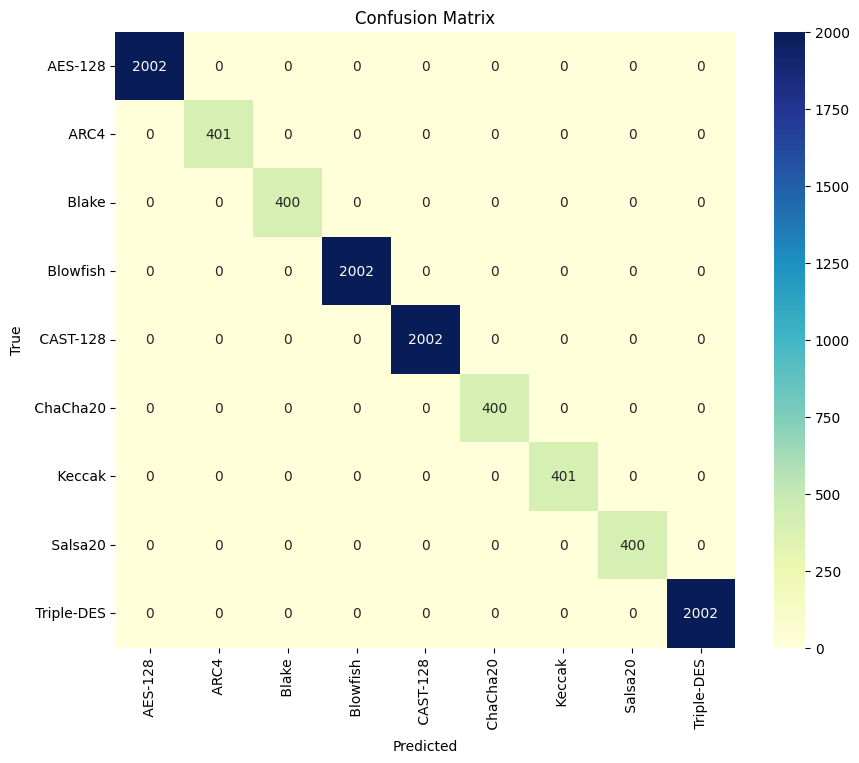

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import StackingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Step 1: Preprocess the Dataset
# Label encoding the target variable
label_encoder = LabelEncoder()
new_df['algorithm_encoded'] = label_encoder.fit_transform(new_df['1'])  # Adjust column name as necessary
X = new_df.drop(columns=['algorithm', 'algorithm_encoded', '0', '1', '2', '3', '4'])  # Adjust column names
y = new_df['algorithm_encoded']

# Step 2: Check Class Imbalance
print("Original class distribution:", Counter(y))

# Step 3: Shuffle and Split Dataset into Training and Testing Sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=42, stratify=y, shuffle=True  # Shuffle the data
)

# Step 4: Feature Selection Using XGBoost-RFE
def xgboost_rfe_gpu(X, y, n_features_to_select=50):
    xgb_gpu = XGBClassifier(
        use_label_encoder=False,
        eval_metric='mlogloss',
        tree_method='gpu_hist',
        max_depth=4,  # Set the maximum depth of trees to reduce splits
        min_child_weight=5,  # Control the minimum sum of instance weight in a child
        random_state=42
    )
    rfe = RFE(estimator=xgb_gpu, n_features_to_select=n_features_to_select, step=1)
    X_selected = rfe.fit_transform(X, y)
    return X_selected, rfe.support_

X_train_selected, selected_features = xgboost_rfe_gpu(X_train, y_train, n_features_to_select=200)
X_test_selected = X_test.iloc[:, selected_features]

# Step 5: Define Base Models for Stacking
xgb_model = XGBClassifier(
    use_label_encoder=False,
    eval_metric='mlogloss',
    tree_method='gpu_hist',
    max_depth=4,  # Set the maximum depth to limit the number of splits
    min_child_weight=3,  # Set the minimum child weight to reduce splits
    predictor='gpu_predictor',
    random_state=42
)

lgbm_model = LGBMClassifier(
    objective='multiclass',
    num_class=len(Counter(y)),  # Number of unique classes
    device='cpu',  # Use CPU for LightGBM
    random_state=42,
    max_depth=4,  # Set maximum depth to limit splits
    num_leaves=31,  # Set the number of leaves (default 31, lower means fewer splits)
    min_data_in_leaf=10  # Set minimum data in a leaf to control splits
)

# Step 6: Define Stacking Model
stacking_model = StackingClassifier(
    estimators=[
        ('xgb', xgb_model),
        ('lgbm', lgbm_model)
    ],
    final_estimator=LogisticRegression(max_iter=1000),
    cv=5
)

# Step 7: Train the Model
stacking_model.fit(X_train_selected, y_train)

# Step 8: Make Predictions and Evaluate the Model
y_pred = stacking_model.predict(X_test_selected)

# Ensure `target_names` matches the unique classes in `y_test`
unique_classes = sorted(set(y_test))
class_names = label_encoder.inverse_transform(unique_classes)

# Print Classification Metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=class_names))

# Confusion Matrix Visualization
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap="YlGnBu")
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [ ]:
import joblib

# Save the model to a file
joblib.dump(stacking_model, '/content/drive/MyDrive/Model-Sih-1/stacking1_total_stream_model.pkl')

# Load the model back
loaded_model = joblib.load('/content/drive/MyDrive/Model-Sih-1/stacking1_total_model.pkl')

# Use the loaded model for predictions
y_pred = loaded_model.predict(X_test_selected)


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:38:32] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


In [ ]:

# Define features and target
label_encoder = LabelEncoder()
X = df.drop(columns=["algorithm", '0','1', '2', '3','4'])  # Drop the target column to get the features
y = df["algorithm"]  # Target variable (e.g., AES-128, Triple-DES, etc.)
y_encoded = label_encoder.fit_transform(y)
y=y_encoded
# Split into training+validation and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Further split training+validation into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42, stratify=y_train_val)


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
import joblib

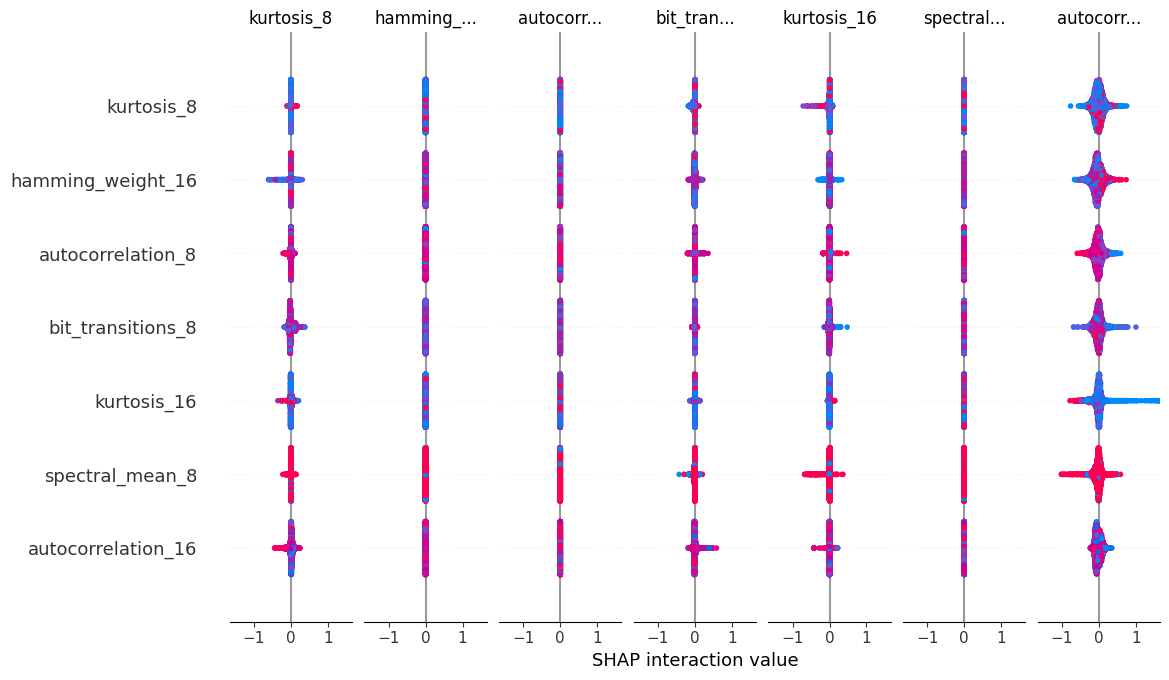

In [ ]:
import shap
import xgboost as xgb

# Train an XGBoost model with GPU support
model = xgb.XGBClassifier(
    eval_metric='mlogloss',
    tree_method='hist',  # Use histogram method (compatible with both CPU and GPU)
    device='cuda'        # Explicitly set to use GPU
)
model.fit(X_train, y_train)

# Explain model predictions using SHAP
explainer = shap.TreeExplainer(model)  # SHAP will automatically leverage GPU for XGBoost models on CUDA
shap_values = explainer.shap_values(X_test)

# Plot SHAP summary
shap.summary_plot(shap_values, X_test)


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, accuracy_score
import numpy as np

# Load dataset
df = updated_dataset  # Use the dataset with extracted features

# Define features and target
X = df.drop(columns=["algorithm", 0, 1, 2, 3,4]) # Feature matrix
y = pd.get_dummies(df["algorithm"])  # One-hot encode target variable

# Split dataset
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=df["algorithm"])
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42, stratify=y_train_val.values.argmax(axis=1))

# Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Define the DNN model
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(y.shape[1], activation='softmax')  # Output layer for multi-class classification
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)

# Train the model
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=32, callbacks=[early_stopping])

# Save the trained model
model_path = "dnn_model.h5"
model.save(model_path)
print(f"DNN Model saved to {model_path}")

# Load the model
loaded_model = load_model(model_path)

# Evaluate the loaded model on the test set
y_test_pred = loaded_model.predict(X_test)
y_test_pred_classes = np.argmax(y_test_pred, axis=1)
y_test_true_classes = np.argmax(y_test.values, axis=1)

print("\nTest Set Classification Report:\n", classification_report(y_test_true_classes, y_test_pred_classes))
print("Test Set Accuracy Score:", accuracy_score(y_test_true_classes, y_test_pred_classes))


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

In [ ]:
updated_dataset=pd.read_csv("/content/drive/MyDrive/new_df1_12.csv")

In [ ]:
updated_dataset.shape

(25025, 301)

In [ ]:
k=updated_dataset.copy()

In [ ]:
def remove_missing_features(dataset, segment_sizes):
    """
    Remove additional features introduced in the second code from the dataset.

    Parameters:
        dataset (pd.DataFrame): Dataset containing features.
        segment_sizes (list): List of segment sizes.

    Returns:
        pd.DataFrame: Updated dataset with specified features removed.
    """
    # Features to remove (fixed missing commas)
    features_to_remove = [
        "fractal_dimension",
        "complexity",
        "spectral_mean",
        "spectral_variance",
        "spectral_entropy",
        "entropy_gradient_mean",
        "convolution",
        #"convolution_mean",
        "power_spectral_peak",
        "hamming_weight",
        "adjacent_bit_probability",
        "bit_transitions",
        "dominant_frequency_magnitude",
        # "bit_pair_freq",
        "hurst_exponent",
        "recurrence_rate",
        "dfa",
        "skewness",
        "frequency_deviation",
        "mean_run_0",
        "mean_run_1",
        "entropy",
        "autocorrelation",
        "chi_square"
    ]

    # Generate column names to remove
    columns_to_remove = []
    for feature in features_to_remove:
        for size in segment_sizes:
            if feature == "power_spectral_peak":
                # Handle multiple peaks (e.g., power_spectral_peak_1, power_spectral_peak_2, ...)
                columns_to_remove.extend([col for col in dataset.columns if col.startswith(f"{feature}_") and col.endswith(f"_{size}")])
            else:
                columns_to_remove.append(f"{feature}_{size}")

    # Drop the columns from the dataset (ignore missing columns)
    dataset = dataset.drop(columns=columns_to_remove, )
    return dataset



In [ ]:
# Dataset with all features

# Segment sizes used for feature extraction
segment_sizes = [128, 256, 512, 1024, 2048, 4096]

# Remove the additional features
cleaned_dataset = remove_missing_features(updated_dataset, segment_sizes)


In [ ]:
cleaned_dataset.shape

(25025, 169)

In [ ]:
cleaned_dataset[2].apply(len).unique()

(222,)

In [ ]:
import pandas as pd

# Example: Assume 'cleaned_dataset' is your DataFrame
# cleaned_dataset = pd.DataFrame(...)  # Your dataset

# Convert the column names to a DataFrame for better display
column_names = pd.DataFrame(cleaned_dataset.columns, columns=["Column Names"])

# Display the complete list using pd.display
pd.set_option('display.max_rows', None)  # Ensures all rows are shown
display(column_names)  # Will display all column names in a scrollable format


,Column Names
0,0
1,1
2,2
3,3
4,algorithm
5,4
6,kurtosis_128
7,kurtosis_256
8,kurtosis_512
9,kurtosis_1024


In [ ]:
new_df=cleaned_dataset.copy()

In [ ]:
new_df.shape

(25025, 163)

Original class distribution: Counter({0: 5005, 8: 5005, 3: 5005, 4: 5005, 2: 1001, 6: 1001, 1: 1001, 5: 1001, 7: 1001})


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [16:51:08] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [16:51:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [16:51:10] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [16:51:10] WARNING: /workspace/src/common/

[ True  True  True  True  True  True  True False False False  True False
 False False  True False False  True  True  True False  True  True False
 False  True False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False  True  True
  True  True False False False  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True]


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [16:53:18] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [16:53:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003646 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4537
[LightGBM] [Info] Number of data points in the train set: 20020, number of used features: 50
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -3.218626
[LightGBM] [Info] Start training from score -3.218626
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -3.218626
[LightGBM] [Info] Start training from score -3.219875
[LightGBM] [Info] Start training from score -3.218626
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [16:53:20] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [16:53:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [16:53:21] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [16:53:21] WARNING: /workspac

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000873 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4466
[LightGBM] [Info] Number of data points in the train set: 16016, number of used features: 50
[LightGBM] [Info] Start training from score -1.609500
[LightGBM] [Info] Start training from score -3.218314
[LightGBM] [Info] Start training from score -3.219875
[LightGBM] [Info] Start training from score -1.609500
[LightGBM] [Info] Start training from score -1.609500
[LightGBM] [Info] Start training from score -3.218314
[LightGBM] [Info] Start training from score -3.219875
[LightGBM] [Info] Start training from score -3.218314
[LightGBM] [Info] Start training from score -1.609188
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] 

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [16:53:34] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist

Accuracy: 0.7232767232767233
Classification Report:
               precision    recall  f1-score   support

     AES-128       1.00      1.00      1.00      1001
        ARC4       0.00      0.00      0.00       200
       Blake       1.00      1.00      1.00       200
    Blowfish       0.47      0.60      0.53      1001
    CAST-128       1.00      1.00      1.00      1001
    ChaCha20       0.00      0.00      0.00       200
      Keccak       1.00      1.00      1.00       201
     Salsa20       0.00      0.00      0.00       200
  Triple-DES       0.46      0.62      0.53      1001

    accuracy                           0.72      5005
   macro avg       0.55      0.58      0.56      5005
weighted avg       0.67      0.72      0.69      5005



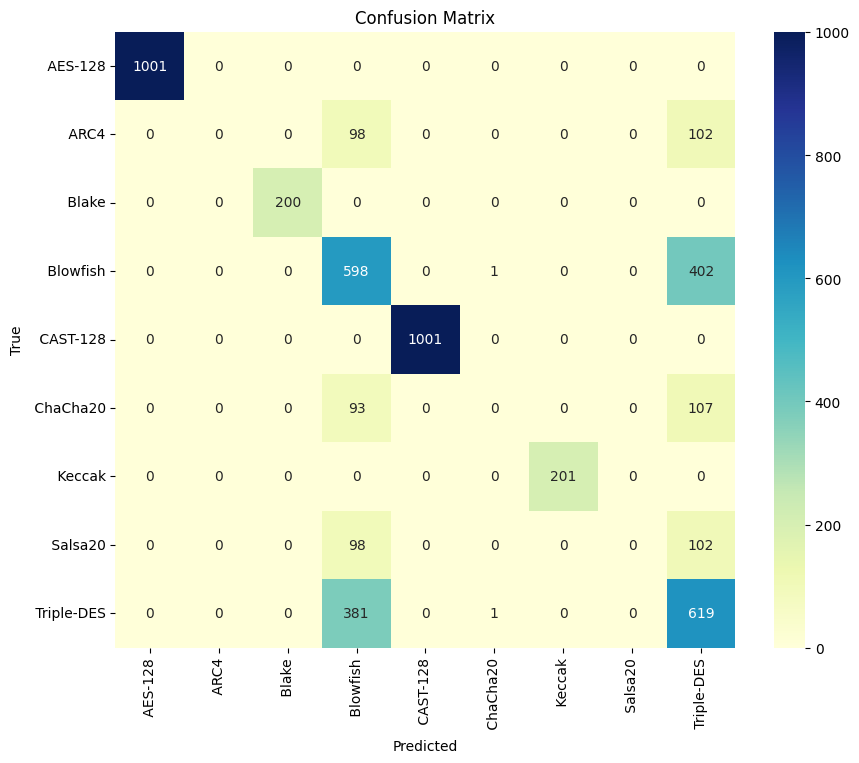

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import StackingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Step 1: Preprocess the Dataset
# Label encoding the target variable
label_encoder = LabelEncoder()
new_df['algorithm_encoded'] = label_encoder.fit_transform(new_df['1'])  # Adjust column name as necessary
X = new_df.drop(columns=['algorithm', 'algorithm_encoded', '0', '1', '2', '3', '4'])  # Adjust column names
y = new_df['algorithm_encoded']

# Step 2: Check Class Imbalance
print("Original class distribution:", Counter(y))

# Step 3: Split Dataset into Training and Testing Sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Step 4: Feature Selection Using XGBoost-RFE
def xgboost_rfe_gpu(X, y, n_features_to_select=50):
    xgb_gpu = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', tree_method='gpu_hist')
    rfe = RFE(estimator=xgb_gpu, n_features_to_select=n_features_to_select, step=1)
    X_selected = rfe.fit_transform(X, y)
    return X_selected, rfe.support_

X_train_selected, selected_features = xgboost_rfe_gpu(X_train, y_train, n_features_to_select=50)
print(selected_features)
X_test_selected = X_test.iloc[:, selected_features]

# Step 5: Define Base Models for Stacking
xgb_model = XGBClassifier(
    use_label_encoder=False,
    eval_metric='mlogloss',
    tree_method='gpu_hist',
    predictor='gpu_predictor',
    random_state=42
)

lgbm_model = LGBMClassifier(
    objective='multiclass',
    num_class=len(Counter(y)),  # Number of unique classes
    device='cpu',  # Use CPU for LightGBM
    random_state=42
)

# Step 6: Define Stacking Model
stacking_model = StackingClassifier(
    estimators=[
        ('xgb', xgb_model),
        ('lgbm', lgbm_model)
    ],
    final_estimator=LogisticRegression(max_iter=1000),
    cv=5
)

# Step 7: Train the Model
stacking_model.fit(X_train_selected, y_train)

# Step 8: Make Predictions and Evaluate the Model
y_pred = stacking_model.predict(X_test_selected)

# Ensure `target_names` matches the unique classes in `y_test`
unique_classes = sorted(set(y_test))
class_names = label_encoder.inverse_transform(unique_classes)

# Print Classification Metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=class_names))

# Confusion Matrix Visualization
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap="YlGnBu")
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [ ]:
new_df.shape

(25025, 169)